## BFast development notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from BFast import get_triangles, Bk
from BFast.core.utils import shard_3D_array

%matplotlib inline

In [3]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

In [4]:
res = 256

In [5]:
b_bins = jnp.arange(1,29)
# b_bins = jnp.arange(1,res//3+1)
b_bins[-1], b_bins.shape[0]-1

(Array(28, dtype=int32), 27)

In [6]:
%time B_info = jax.block_until_ready(get_triangles(b_bins, False))
%time B_info = jax.block_until_ready(get_triangles(b_bins, False))

CPU times: user 613 ms, sys: 16.4 ms, total: 630 ms
Wall time: 970 ms
CPU times: user 20.3 ms, sys: 4.08 ms, total: 24.4 ms
Wall time: 17.2 ms


In [7]:
B_info['triangle_centers'].shape, B_info['triangle_indices'].shape

((2107, 3), (2107, 3))

In [8]:
field = jnp.array(jax.random.normal(jax.random.PRNGKey(2), (res,)*3))
field_np = np.array(field)
field.shape

(256, 256, 256)

In [9]:
sharded_field = shard_3D_array(field)

In [10]:
for s in sharded_field.addressable_shards:
    print(s.data.shape, s.data.nbytes*1e-9, s.data.nbytes*1e-9 * b_bins.shape[0]-1)

(256, 64, 256) 0.016777216 -0.530237952
(256, 64, 256) 0.016777216 -0.530237952
(256, 64, 256) 0.016777216 -0.530237952
(256, 64, 256) 0.016777216 -0.530237952


In [11]:
sharded_field.sharding

NamedSharding(mesh=Mesh('gpus': 4, axis_types=(Auto,)), spec=PartitionSpec(None, 'gpus'), memory_kind=device)

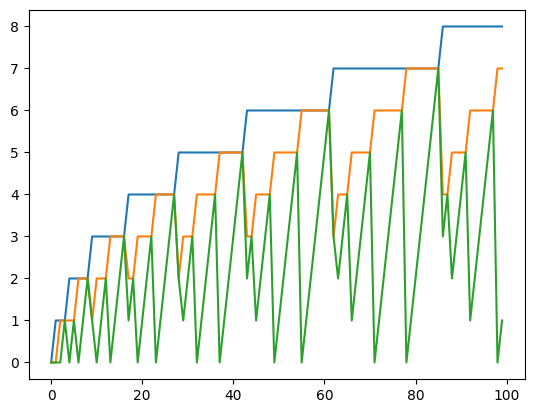

In [12]:
plt.plot(B_info['triangle_indices'][:100])

In [13]:
from BFast import Bk

In [14]:
%time testy = jax.block_until_ready(Bk(field, **B_info, fast=True))
%timeit jax.block_until_ready(Bk(field, **B_info, fast=True))
testy

CPU times: user 1.05 s, sys: 172 ms, total: 1.22 s
Wall time: 1.61 s
448 ms ± 331 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Array([ 1.7653949e+12,  9.9733111e+11,  2.7821445e+12, ...,
       -2.2592662e+14, -1.9275793e+14, -1.1571826e+14], dtype=float32)

In [15]:
%time testy = jax.block_until_ready(Bk(sharded_field, **B_info, fast=True, sharding=sharded_field.sharding))
%timeit jax.block_until_ready(Bk(sharded_field, **B_info, fast=True, sharding=sharded_field.sharding))
testy

/leonardo/home/userexternal/tfloess0/.venv/main/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: float32[256,64,256].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
/leonardo/home/userexternal/tfloess0/.venv/main/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py:1233: UserWarning: Some donated buffers were not usable: complex64[256,256,129].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


CPU times: user 2.04 s, sys: 2.58 s, total: 4.62 s
Wall time: 2.94 s
1.5 s ± 6.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Array([ 1.7653954e+12,  9.9733071e+11,  2.7821442e+12, ...,
       -2.2592665e+14, -1.9275801e+14, -1.1571820e+14], dtype=float32)

In [16]:
%time testy = jax.block_until_ready(Bk.jit(field, **B_info, fast=True))
%timeit jax.block_until_ready(Bk.jit(field, **B_info, fast=True))
testy

CPU times: user 421 ms, sys: 155 ms, total: 576 ms
Wall time: 668 ms
304 ms ± 108 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Array([ 1.7653949e+12,  9.9733111e+11,  2.7821445e+12, ...,
       -2.2592662e+14, -1.9275793e+14, -1.1571826e+14], dtype=float32)

In [17]:
%time testy = jax.block_until_ready(Bk.jit(sharded_field, **B_info, fast=True, sharding=sharded_field.sharding, compute_norm=False))
%timeit jax.block_until_ready(Bk.jit(sharded_field, **B_info, fast=True, sharding=sharded_field.sharding))
testy

CPU times: user 1.13 s, sys: 299 ms, total: 1.43 s
Wall time: 1.26 s
131 ms ± 232 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Array([ 1.7653954e+12,  9.9733071e+11,  2.7821442e+12, ...,
       -2.2592665e+14, -1.9275801e+14, -1.1571820e+14], dtype=float32)

In [18]:
%time testy = jax.block_until_ready(Bk.jit(field, **B_info, fast=False))
%time jax.block_until_ready(Bk.jit(field, **B_info, fast=False))
testy

CPU times: user 2.8 s, sys: 16.2 ms, total: 2.82 s
Wall time: 2.86 s
CPU times: user 2.52 s, sys: 0 ns, total: 2.52 s
Wall time: 2.53 s


Array([ 1.7653949e+12,  9.9733111e+11,  2.7821445e+12, ...,
       -2.2592662e+14, -1.9275793e+14, -1.1571826e+14], dtype=float32)

In [19]:
%time testy = jax.block_until_ready(Bk.jit(sharded_field, **B_info, fast=False, sharding=sharded_field.sharding))
%time jax.block_until_ready(Bk.jit(sharded_field, **B_info, fast=False, sharding=sharded_field.sharding))
testy

CPU times: user 6.5 s, sys: 28.1 ms, total: 6.53 s
Wall time: 2.02 s
CPU times: user 6.07 s, sys: 0 ns, total: 6.07 s
Wall time: 1.52 s


Array([ 1.7653954e+12,  9.9733071e+11,  2.7821442e+12, ...,
       -2.2592665e+14, -1.9275801e+14, -1.1571820e+14], dtype=float32)

--------  Memory usage of bisp  ---------
const : 48 B
code  : 34.8 kB
temp  : 11.0 GB
arg   : 216.0 MB
output: 7.4 kB
alias : 0 B
peak  : 11.2 GB


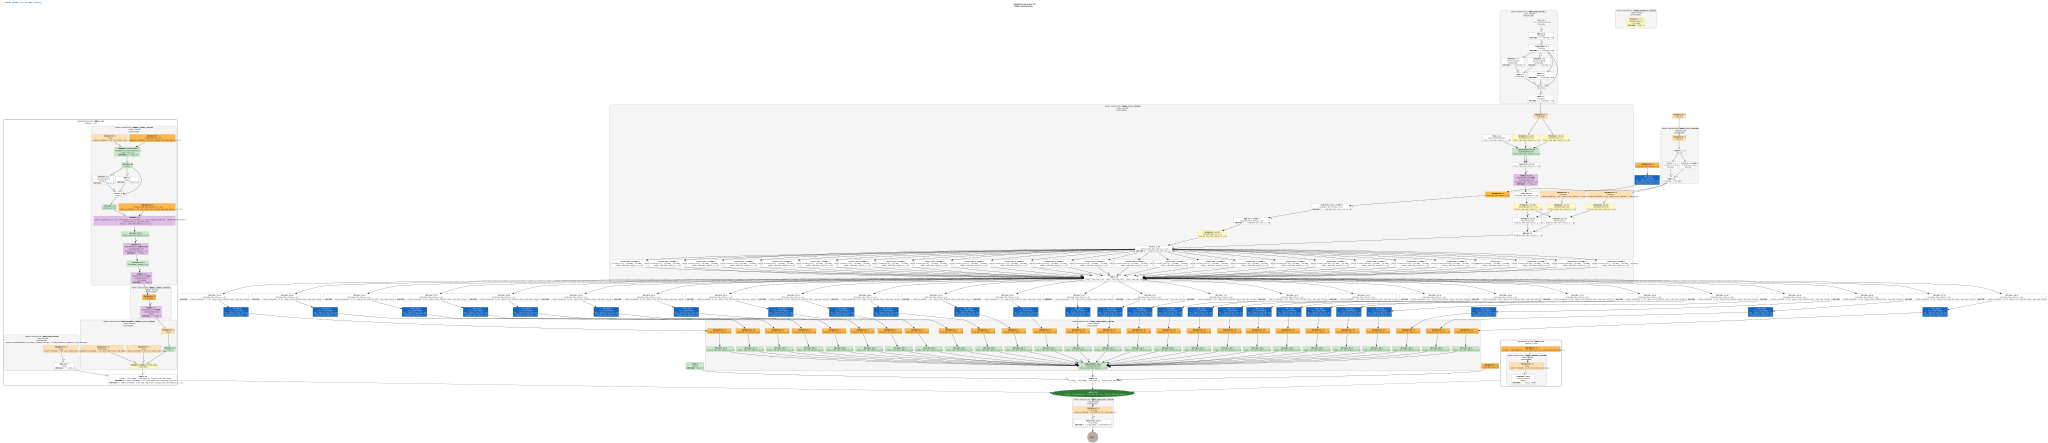

In [20]:
show_hlo_info(bisp.jit, field, b_bins, triangle_centers, triangle_indices, width=2000)

--------  Memory usage of bisp  ---------
const : 64 B
code  : 33.0 kB
temp  : 1.6 GB
arg   : 216.0 MB
output: 7.4 kB
alias : 0 B
peak  : 1.8 GB


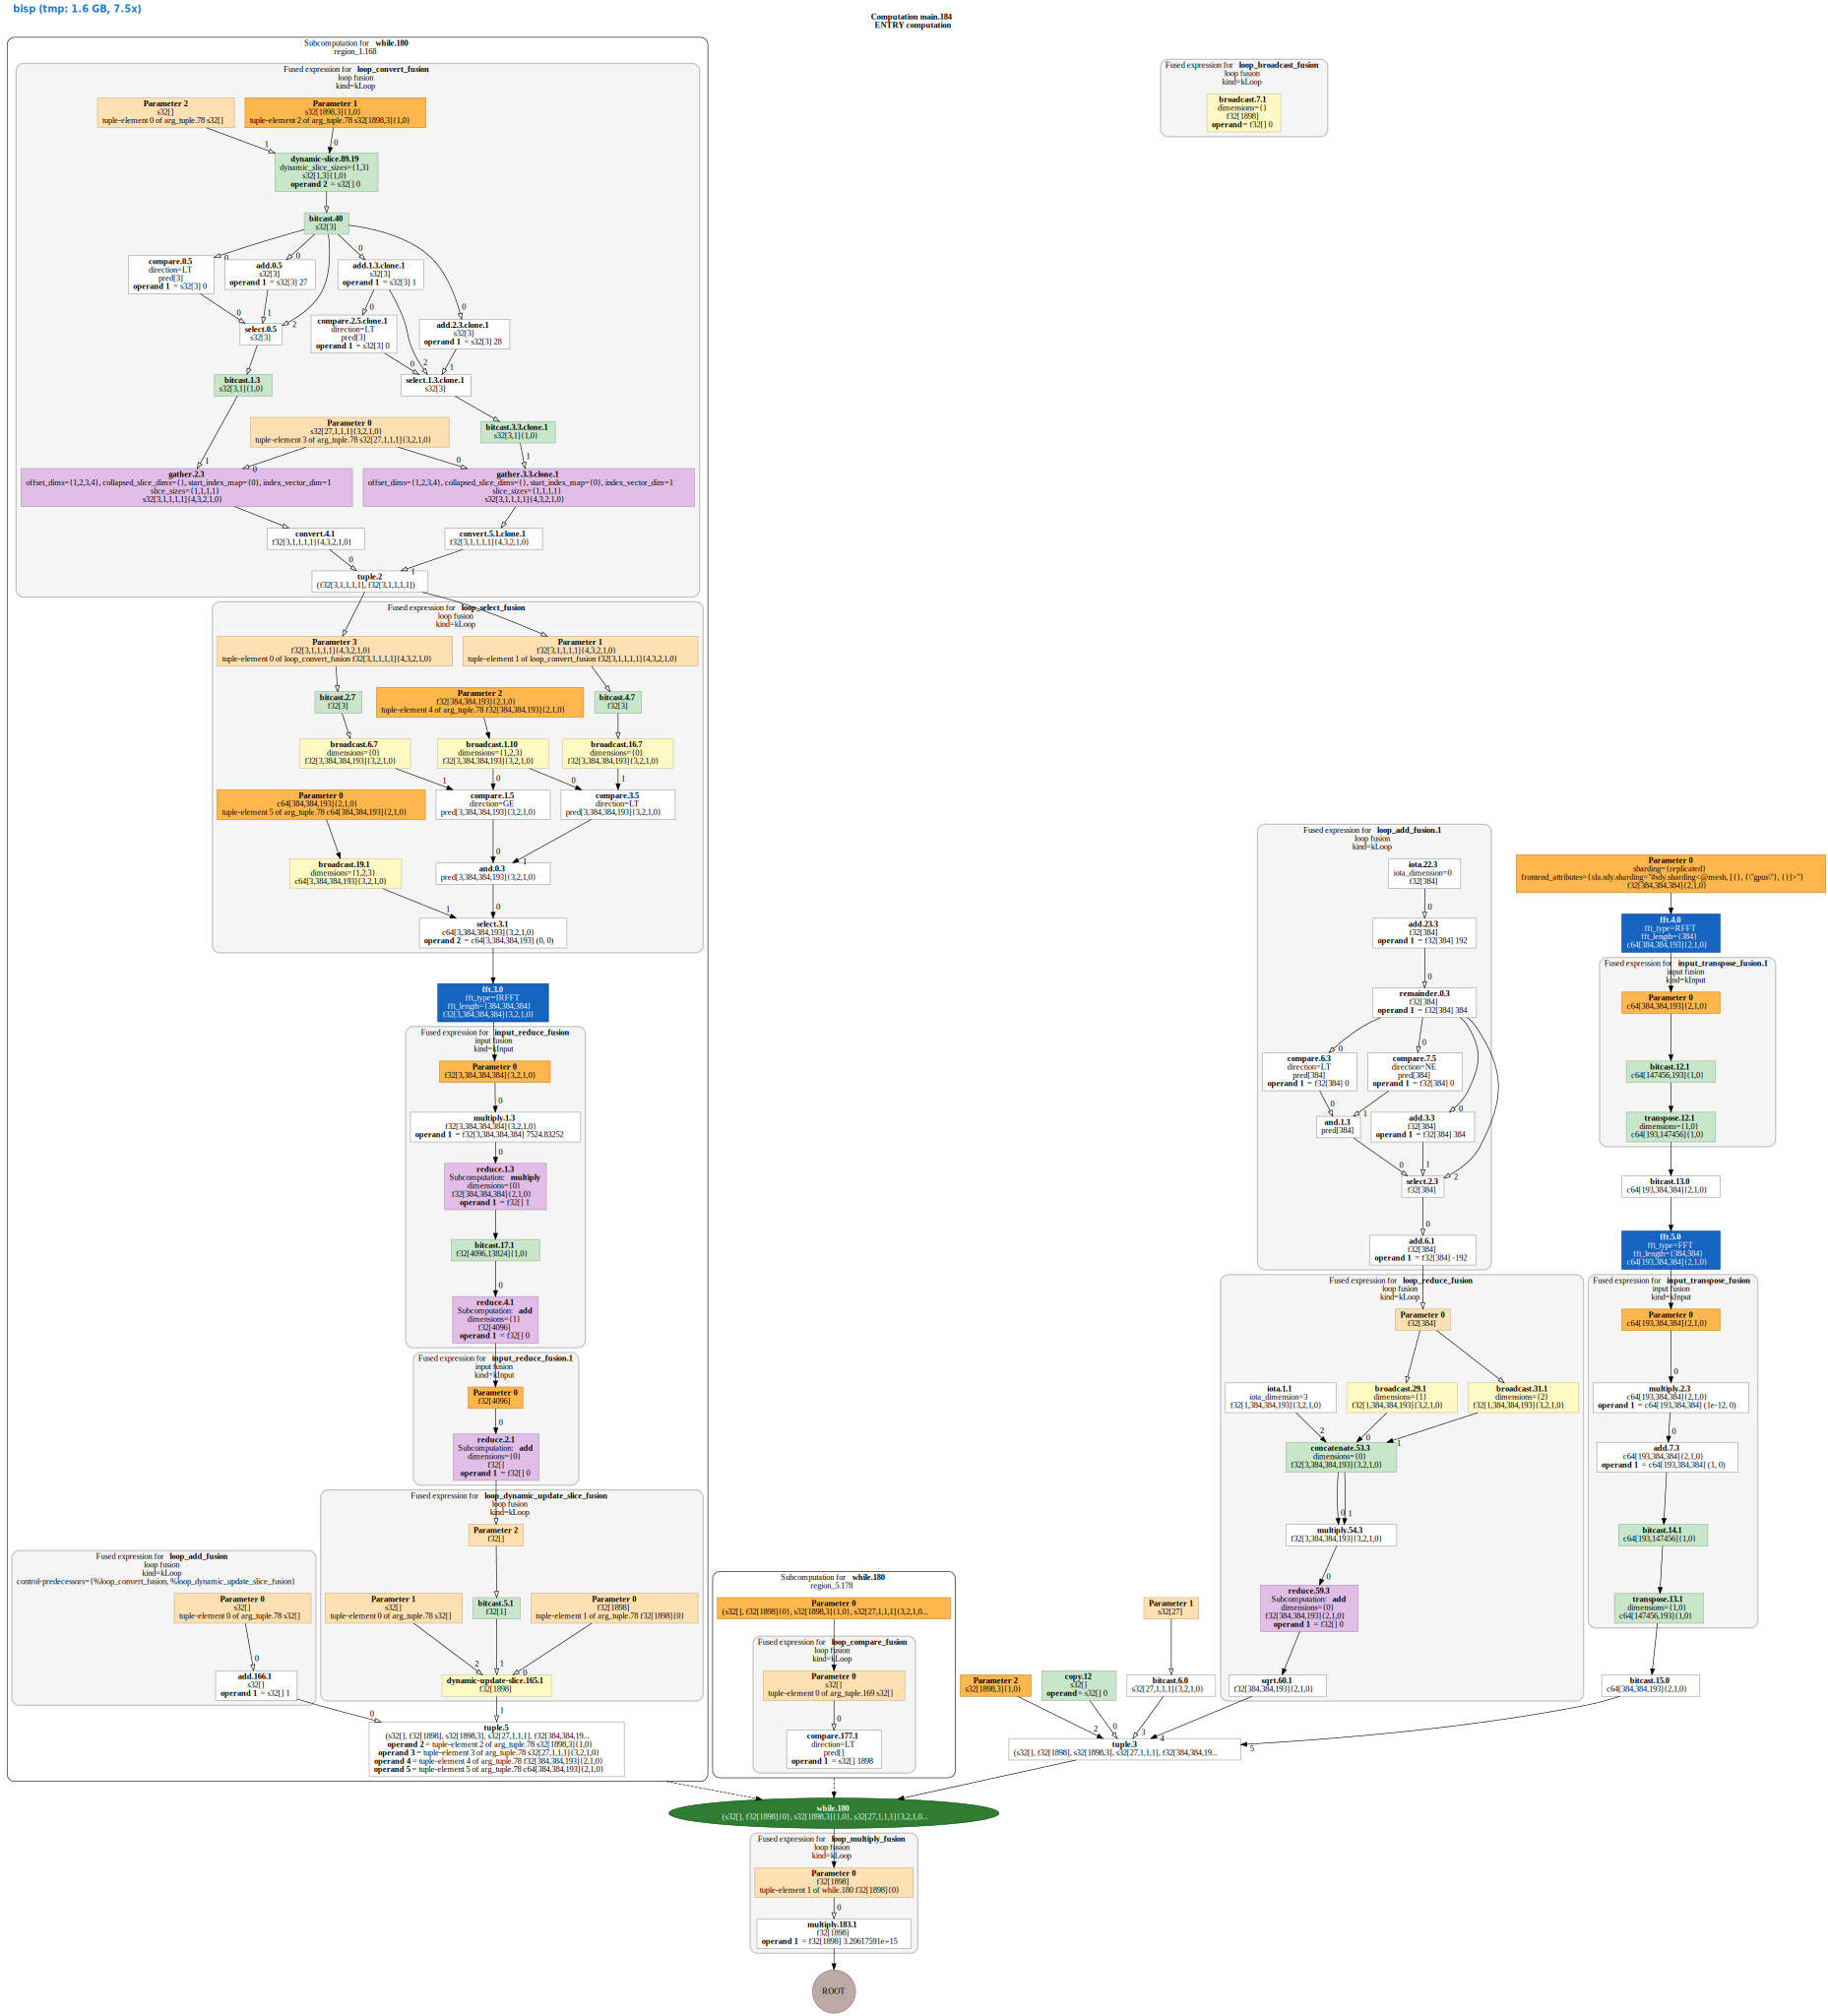

In [21]:
show_hlo_info(bisp.jit, sharded_field, b_bins, triangle_centers, triangle_indices,sharded=True, fast=False, width=2000)

In [ ]:
def bisp(field, b_bins, triangle_centers, triangle_indices, open_triangles=True, fast=True):
    bin_edges = b_bins[:,None,None,None]
    bin_low = b_bins[:-1][:,None,None,None]
    bin_high = b_bins[1:][:,None,None,None]

    res = field.shape[0]
    kx = jnp.fft.fftfreq(res, 1/res)
    kz = jnp.fft.rfftfreq(res, 1/res)
    kvec = jnp.array(jnp.meshgrid(kx, kx, kz, indexing='ij'))
    kmag = jnp.sqrt((kvec**2).sum(0))

    fft_axes = (-3,-2,-1)

    field = jnp.fft.rfftn(field, axes=fft_axes)
    field = field*0. + 1.
    
    if fast:
        bin_filters = (kmag >= bin_low) * (kmag < bin_high)
        field = bin_filters * field
        bin_filters = jnp.fft.irfftn(field, axes=(-3,-2,-1), norm='ortho')
        _, Bk = jax.lax.scan(jax.checkpoint(
            lambda c, t: (0., bin_filters[t].prod(0).sum())), init=0.,
            xs=triangle_indices)

    else:
        def _B(carry, t):
            bin_filter = (kmag >= bin_edges[t]) * (kmag < bin_edges[t + 1])
            fields = bin_filter * field
            fields = jnp.fft.irfftn(fields, axes=fft_axes, norm='ortho')
            return 0., fields.prod(0).sum()

        _, Bk = jax.lax.scan(jax.checkpoint(_B), init=0., xs=triangle_indices)
        

    Bk *= res**1.5
    return Bk

bisp.jit = jax.jit(bisp, static_argnames='fast')
    
%time testy = jax.block_until_ready(bisp.jit(sharded_array, b_bins, triangle_centers, triangle_indices, fast=True))
%timeit jax.block_until_ready(bisp.jit(sharded_array, b_bins, triangle_centers, triangle_indices, fast=True))
testy